In [ ]:
'''
Available methods are the followings:
[1] BetaCalibration
[2] ABM_BetaCal
[3] AB_BetaCal
[4] AM_BetaCal
[5] Sigmoid_Cal
[6] ModifiedLogistic
[7] calibration_metrics

Authors: Danusorn Sitdhirasdr <danusorn.si@gmail.com>
versionadded:: 30-10-2025

'''
import numpy as np
from collections import namedtuple
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import column_or_1d, check_consistent_length
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.validation import (check_array, check_is_fitted, 
                                      _check_sample_weight, check_X_y)
from sklearn.utils.multiclass import type_of_target
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import QuantileTransformer
from scipy.optimize import minimize_scalar, minimize
from scipy.stats import norm

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib import font_manager as fm, cm
from matplotlib.ticker import (FixedLocator, 
                               FixedFormatter, 
                               StrMethodFormatter,
                               FuncFormatter)

paths = fm.findSystemFonts(fontpaths=None, fontext='ttf')
for font_path in paths:
    if font_path.find("Hiragino Sans GB W3")>-1:
        fm.fontManager.addfont(font_path)
        prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = prop.get_name()
        plt.rcParams.update({'font.family':'sans-serif'})
        plt.rcParams.update({'font.sans-serif':prop.get_name()})
        
plt.rc('axes', unicode_minus=False)

In [ ]:
__all__ = ["BetaCalibration",
           "ABM_BetaCal",
           "AB_BetaCal",
           "AM_BetaCal", 
           "Sigmoid_Cal",
           "ModifiedLogistic", 
           "calibration_metrics"]

In [ ]:
class ValidateParams:
    
    '''Validate parameters'''
    
    def Interval(self, Param, Value, dtype=int, 
                 left=None, right=None, closed="both"):

        '''
        Validate numerical input.

        Parameters
        ----------
        Param : str
            Parameter's name

        Value : float or int
            Parameter's value

        dtype : {int, float}, default=int
            The type of input.

        left : float or int or None, default=None
            The left bound of the interval. None means left bound is -∞.

        right : float, int or None, default=None
            The right bound of the interval. None means right bound is +∞.

        closed : {"left", "right", "both", "neither"}
            Whether the interval is open or closed. Possible choices are:
            - "left": the interval is closed on the left and open on the 
              right. It is equivalent to the interval [ left, right ).
            - "right": the interval is closed on the right and open on the 
              left. It is equivalent to the interval ( left, right ].
            - "both": the interval is closed.
              It is equivalent to the interval [ left, right ].
            - "neither": the interval is open.
              It is equivalent to the interval ( left, right ).

        Returns
        -------
        Value : float or int
            Parameter's value

        '''
        Options = {"left"    : (np.greater_equal, np.less), # a<=x<b
                   "right"   : (np.greater, np.less_equal), # a<x<=b
                   "both"    : (np.greater_equal, np.less_equal), # a<=x<=b
                   "neither" : (np.greater, np.less)} # a<x<b

        f0, f1 = Options[closed]
        c0 = "[" if f0.__name__.find("eq")>-1 else "(" 
        c1 = "]" if f1.__name__.find("eq")>-1 else ")"
        v0 = "-∞" if left is None else str(dtype(left))
        v1 = "+∞" if right is None else str(dtype(right))
        if left  is None: left  = -np.inf
        if right is None: right = +np.inf
        interval = ", ".join([c0+v0, v1+c1])
        tuples = (Param, dtype.__name__, interval, Value)
        err_msg = "%s must be %s or in %s, got %s " % tuples    

        if isinstance(Value, dtype):
            if not (f0(Value, left) & f1(Value, right)):
                raise ValueError(err_msg)
        else: raise ValueError(err_msg)
        return Value

    def StrOptions(self, Param, Value, options, dtype=str):

        '''
        Validate string or boolean inputs.

        Parameters
        ----------
        Param : str
            Parameter's name
            
        Value : float or int
            Parameter's value

        options : set of str
            The set of valid strings.

        dtype : {str, bool}, default=str
            The type of input.
        
        Returns
        -------
        Value : float or int
            Parameter's value

        '''
        if Value not in options:
            err_msg = f'{Param} ({dtype.__name__}) must be either '
            for n,s in enumerate(options):
                if n<len(options)-1: err_msg += f'"{s}", '
                else: err_msg += f' or "{s}" , got %s'
            raise ValueError(err_msg % Value)
        return Value
    
    def check_range(self, param0, param1):
        
        '''
        Validate number range.
        
        Parameters
        ----------
        param0 : tuple(str, float)
            A lower bound parameter e.g. ("name", -100.)
            
        param1 : tuple(str, float)
            An upper bound parameter e.g. ("name", 100.)
            
        '''
        if param0[1] >= param1[1]:
            raise ValueError(f"`{param0[0]}` ({param0[1]}) must be less"
                             f" than `{param1[0]}` ({param1[1]}).")
            
    def check_y_inputs(self, y_proba, y_true=None):
        
        '''
        Validate inputs for calibration models.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Predicted probabilities ranges from 0 to 1.
            
        y_true : array-like, shape (n_samples,), default=None
            True binary labels (0/1).
            
        Returns
        -------
        y_proba : ndarray shape (n_samples,)
            Validated probabilities.
            
        y_true : ndarray shape (n_samples,)
            Validated labels. This returns None when `y_ture` is not 
            provided.
            
        '''
        # Ensure shapes
        y_proba = column_or_1d(y_proba)
        y_proba = check_array(y_proba, ensure_2d=False, dtype=float)

        # Probability range
        eps = np.finfo(float).eps
        y_proba = np.clip(y_proba, eps, 1 - eps)
        
        if y_true is not None:
            
            # Check lengths
            y_true = column_or_1d(y_true)
            check_consistent_length(y_proba, y_true)

            # Check that y_true only contains {0,1}
            unique_labels = np.unique(y_true)
            if not np.all(np.isin(unique_labels, [0, 1])):
                raise ValueError("`y_true` must be binary (0 or 1).")
            return y_proba, y_true
        
        else: return y_proba, None
        
    def check_class_weight(self, class_weight):
        
        '''
        Validate the `class_weight` parameter.

        Parameters
        ----------
        class_weight : {dict, "balanced"} or None
            Weights associated with classes in the form `{label: weight}`.
            If set to "balanced", the weights are automatically adjusted
            inversely proportional to class frequencies.

        Returns
        -------
        class_weight : dict, str or None
            Normalized class_weight.
            
        '''
         # Validate the `class_weight` parameter.
        if class_weight is None:
            return None
        elif isinstance(class_weight, str):
            args = ("class_weight", class_weight, ["balanced"], str)
            return self.StrOptions(*args)
        elif isinstance(class_weight, dict):
            return class_weight
        else:raise ValueError(f"Invalid value for `class_weight`: {class_weight}. "
                              f"Expected dict, 'balanced', or None.")
            
    def check_estimator(self, estimator):
        
        '''
        Validate that an estimator follows sklearn interface.

        Parameters
        ----------
        estimator : object
            Estimator instance.

        Raises
        ------
        ValueError
            If estimator does not implement required methods/attributes.
            
        '''
        for m in ["get_params", "set_params", "fit", "predict", "predict_proba"]:
            if not callable(getattr(estimator, m, None)):
                raise ValueError(f"Estimator missing required method `{m}()`.")

        if estimator.get_params().get("fit_intercept", None) is None:
            raise ValueError("Estimator missing required parameter "
                             "`fit_intercept` in get_params().")
        
        # Fit model with dummy X and y
        N, rnd = 10, np.random.RandomState(0)
        estimator.fit(rnd.rand(N).reshape(-1,1), 
                      rnd.randint(0, 2, size=N))
        
        for a in ["coef_", "intercept_"]:
            if getattr(estimator, a, None) is None:
                raise ValueError(f"Estimator missing required attribute "
                                 f"`{attr}` after fit().")

    def check_bins(self, bins, data=None):
        
        '''
        Validate 'bins'

        Parameters
        ----------
        bins : int, sequence
            Number of bins or sequence to divide probabilities.
            
        Returns
        -------
        bins : int, sequence
            
        '''
        # Case 1: bins is integer
        if isinstance(bins, int):
            if bins <= 0:
                raise ValueError(f"Number of bins must be positive,"
                                 f" got {bins}.")

        # Case 2: bins is a sequence of bin edges
        elif isinstance(bins, (list, np.ndarray)):
            
            bins = np.asarray(bins)
            if bins.ndim != 1:
                raise ValueError("Bin edges must be a 1D sequence")
            elif not np.all(np.isfinite(bins)):
                raise ValueError("Bin edges contain non-finite values (NaN/inf)")
            elif not np.all(np.diff(bins) > 0):
                raise ValueError("Bin edges must be strictly increasing")
            elif len(bins) < 2:
                raise ValueError("At least two bin edges are required")
            else: pass

        else: raise TypeError("bins must be int or sequence")
        
        return bins

In [ ]:
class AxFormatter:
    
    '''Helper class for consistent matplotlib axis formatting'''

    def add_vertical_line(self, ax: plt.Axes, x: float, text: str):
        
        '''Draw a vertical line with label above it.'''
        ax.axvline(x, lw=0.5, color="k", zorder=-1)

        # Add a minor tick at the line position
        ax.xaxis.set_minor_locator(FixedLocator([x]))
        ax.tick_params(axis="x", which="minor", length=3, color="k")

        # Add text label above the line
        args = (ax.transData, ax.transAxes)
        ax.text(x, 1.01, text,  fontsize=13, va='bottom', ha="center", 
                transform=transforms.blended_transform_factory(*args))

    def add_axis_labels(self, ax: plt.Axes, ylabel: str, xlabel: str):
        
        '''Set axis labels and background style'''
        ax.set_ylabel(ylabel, fontsize=13)
        ax.set_xlabel(xlabel, fontsize=13)
        ax.set_facecolor("white")
        ax.patch.set_alpha(0)

    def add_axis_text(self, ax: plt.Axes, ytext: str, xtext: str):
        
        '''Add text annotations to the ends of the axes.'''
        args = (ax.transAxes, ax.transAxes)
        transform = transforms.blended_transform_factory(*args)
        ax.text(0, 1.01, ytext, fontsize=13, va='bottom', 
                ha="center", transform=transform)
        ax.text(1.01, 0, xtext, fontsize=13, va='center', 
                ha="left", transform=transform)
        
    def add_calibration_line(self, ax: plt.Axes, x: np.ndarray):
        
        '''Add a reference 'perfect calibration' dashed line.'''
        eps = np.finfo(float).eps
        ax.plot(x, x, ls="--", lw=1, color="grey", 
                label="Perfect Calibration")
        
    def add_annotation(self, ax: plt.Axes, text: str, loc: int):
        
        '''Add annotation'''
        bottom, top = ax.get_ylim()
        left, right = ax.get_xlim()
        
        # Positional arguments
        args = {1: (text, (left , top)),
                2: (text, (right, top)), 
                3: (text, (right, bottom)),
                4: (text, (left , bottom))}
        
        # Keyword arguments
        kwargs = {1 : dict(ha="left" , va="top"   , xytext=( 5,-5)),
                  2 : dict(ha="right", va="top"   , xytext=(-5,-5)),
                  3 : dict(ha="right", va="bottom", xytext=(-5, 5)),
                  4 : dict(ha="left" , va="bottom", xytext=( 5, 5))}
        
        kwds = dict(textcoords='offset points', fontsize=12)
        kwds.update(kwargs[loc])
        ax.annotate(*args[loc], **kwds)

    def format_axis(self, ax: plt.Axes):
        
        '''Apply axis formatting (ticks, spines, and percent scale)'''
        percent_formatter = ticker.PercentFormatter(xmax=1)
        ax.xaxis.set_major_formatter(percent_formatter)
        ax.yaxis.set_major_formatter(percent_formatter)
        ax.yaxis.set_major_locator(ticker.MaxNLocator(6))
        ax.xaxis.set_major_locator(ticker.MaxNLocator(6))
        ax.tick_params(axis="both", labelsize=10.5)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

    def format_legend(self, ax: plt.Axes):
        
        '''Format legend for clean appearance'''
        ax.legend(edgecolor="none", borderaxespad=0.2, 
                  markerscale=1.5, columnspacing=0.3, 
                  handletextpad=0.5, loc="best",
                  prop=dict(size=12)) 

In [ ]:
class calibration_metrics(ValidateParams, AxFormatter):
    
    '''
    Evaluate and visualize calibration metrics.

    Parameters
    ----------
    calibrator : object
        Fitted calibrator that must have method `predict()`.
        
    bins : int or sequence, default=10
        Number of bins or sequence to divide probabilities.
        
    alpha : float, default=0.05
        Confidence interval significance level (two-tailed).
        Assumes normally distributed errors.
        
    strategy : {'uniform', 'normal', 'linear'}, default='linear'
        Strategy for determining bin edges.

    '''
    strategies = ['uniform', 'normal', 'linear']
    colors = ["#1B9CFC", "#FC427B"]
    methods = {"ABM_BetaCal": "Beta (ABM)",
               "AB_BetaCal" : "Beta (AB)",
               "AM_BetaCal" : "Beta (AM)", 
               "Sigmoid_Cal": "Logistic"}
    
    def __init__(self, calibrator, bins=10, alpha=0.05, strategy="linear"):
        
        # Validate all parameters
        self.bins = self.check_bins(bins)
        self.alpha = self.Interval("alpha", alpha, float, 0., 1., "both")
        self.strategy = self.StrOptions('strategy', strategy, self.strategies, str)
        self.z = norm.ppf(1 - self.alpha/2)
        
        # Check if fit() was called
        if not callable(getattr(calibrator, "predict", None)):
            raise ValueError(f"Estimator missing required method `predict()`.")
        else: self.calibrator = calibrator
        
        # Get readable calibrator name
        name = calibrator.__class__.__name__
        if name == "BetaCalibration":
            name = calibrator.calibrator_.__class__.__name__
        self.name = self.methods.get(name, name)
            
    def fit(self, y_true, y_proba):
    
        '''
        Fit model to determine bin edges.

        Parameters
        ----------
        y_true : array-like of shape (n_samples,)
            True binary labels.
            
        y_proba : array-like of shape (n_samples,)
            Uncalibrated probability estimates.

        Returns
        -------
        self : object
            Fitted instance with bin edges.
        
        '''
        y_calib = self.calibrator.predict(y_proba)
    
        if not isinstance(self.bins, int):    
            self.bin_edges = self.bins    
        elif self.strategy in ["uniform", "normal"]:
            kwargs = dict(n_quantiles=100, random_state=0,
                          output_distribution=self.strategy, 
                          subsample=10000, copy=True)
            transformer = QuantileTransformer(**kwargs)
            
            t = transformer.fit_transform(y_calib.reshape(-1,1))
            t = np.histogram(t, bins=self.bins)[1].reshape(-1,1)
            self.bin_edges = transformer.inverse_transform(t).ravel()
        else:
            amin, amax = np.percentile(y_calib, q=[0,100])
            self.bin_edges = np.linspace(amin, amax, self.bins)            

        return self

    def reliability_curve(self, y_true, y_proba, ax=None):

        '''
        Plot reliability evaluation metric. 

        Parameters
        ----------
        y_true : array-like, shape (n_samples,)
            True binary labels.

        y_proba : array-like, shape (n_samples,)
            Uncalibrated probability estimates.

        ax : matplotlib.axes.Axes, default=None
            Predefined Matplotlib axis. If None, a new figure and axis 
            are created.

        Returns
        -------
        ax : matplotlib.axes.Axes
            The axis containing the calibration plot.

        '''
        # Check if fit() was called
        check_is_fitted(self, ["bin_edges"])
        
        # Setup axis and configuration.
        if ax is None: ax = plt.subplots(figsize=(6.5,4.5))[1] 
            
        # Compute per-bin confidence statistics
        output = self.compute_confidence(y_true, y_proba)
        
        # Plot estimated probabilities
        ax.plot(output.est_means, output.act_means, 
                color=self.colors[1], lw=1, ms=5, marker="o", 
                label=f'Estimates - {self.name}')
   
        # Confidence Interval (by Bin)
        label = f'{1-self.alpha:.1%} CI ({output.n_bins:.0f} bins)'
        ax.errorbar(output.est_means, output.est_means, elinewidth=1,
                    yerr=self.z * output.est_error, capsize=5, 
                    fmt="none", ecolor=self.colors[1], label=label)

        # Add perfectly calibrated line
        self.add_calibration_line(ax, output.est_means)
        
        # Expected Calibrated Error, MCE (Maximum Calibration Error) 
        delta = np.abs(output.act_means - output.est_means)
        ece, mce = sum(output.weights * delta), max(delta)
        self.add_annotation(ax, f"ECE = {ece:.2%}, MCE = {mce:.2%}", 3)
        
        # Axis formatting
        self.add_axis_labels(ax, 'Empirical Probability', 'Calibrated Probability')
        self.format_axis(ax)
        self.format_legend(ax)
        plt.tight_layout()
        
        return ax
    
    def calibration_curve(self, y_true, y_proba, ax=None):

        '''
        Plot calibration evaluation metric.

        Parameters
        ----------
        y_true : array-like, shape (n_samples,)
            True binary labels.

        y_proba : array-like, shape (n_samples,)
            Uncalibrated probability estimates.

        ax : matplotlib.axes.Axes, default=None
            Predefined Matplotlib axis. If None, a new figure and axis 
            are created.

        Returns
        -------
        ax : matplotlib.axes.Axes
            The axis containing the calibration plot.

        '''
        # Setup axis
        if ax is None: ax = plt.subplots(figsize=(6.5,4.5))[1] 
        
        # Scatter points for each class
        for n in np.unique(y_true):
            x = np.sort(y_proba[y_true==n])
            y = self.calibrator.predict(x)
            ax.scatter(x, y, color=self.colors[n], marker="o", 
                       s=30, alpha=0.5, label=f"Class {n}")
            
        # Plot calibration curve
        x = np.linspace(0, 1, 101)
        y = self.calibrator.predict(x)
        ax.plot(x, y, lw=0.5, color="b", label=self.name)
        
        # Add perfectly calibrated line
        self.add_calibration_line(ax, x)

        # Mark midpoint (m)
        m = getattr(self.calibrator.params_, "m", None)
        if m is not None: self.add_vertical_line(ax, m, f"m = {m:.2g}")

        # Axis formatting
        self.add_axis_text(ax, r"$\sigma(x)$", "x") 
        self.add_axis_labels(ax, "Calibrated Probability", "Raw Probability")
        self.format_axis(ax)
        self.format_legend(ax)
        plt.tight_layout()
        
        return ax
    
    def compute_confidence(self, y_true, y_proba):
        
        '''
        Compute per-bin confidence statistics.

        Parameters
        ----------
        y_true : array-like, shape (n_samples,)
            True binary labels.

        y_proba : array-like, shape (n_samples,)
            Uncalibrated probability estimates.
            
        Returns
        -------
        Output : namedtuple
            act_means : np.ndarray
            est_means : np.ndarray
            est_error : np.ndarray
            counts    : np.ndarray
            weights   : np.ndarray
            n_bins    : int
        
        '''
        # Check if fit() was called
        check_is_fitted(self, ["bin_edges"])
        
        # Calculate group indices from calibrated probabilities
        y_calib = self.calibrator.predict(y_proba)
        indices = np.digitize(y_calib, bins=self.bin_edges, right=True)
        unq,cnt = np.unique(indices, return_counts=True)
    
        # Calculate empirical accuray and mean confidence
        act_means, est_means, est_error = [], [], []
        for k in unq:
            act_means.append(np.mean(y_true[indices==k]))
            est_means.append(np.mean(y_calib[indices==k]))
            est_error.append(np.std(y_calib[indices==k]))

        # Store results
        data = dict(act_means=np.array(act_means), 
                    est_means=np.array(est_means),
                    est_error=np.array(est_error),
                    counts=cnt, 
                    weights=cnt/sum(cnt),
                    n_bins=len(cnt))
        return namedtuple("Output", data.keys())(**data)

In [ ]:
class EvaluateLoss:
    
    '''
    Utility class to evaluate model performance before and after 
    calibration.

    Metrics:
        - Brier score
        - Log loss
        
    '''
    
    @staticmethod
    def _gini(self, y_true, y_proba):
        
        '''
        Compute Gini coefficient from ROC AUC.
        '''
        return 2 * roc_auc_score(y_true, y_proba) - 1
    
    def _ece(self, y_true, y_proba, n_bins=20):
        
        '''
        Compute Expected Calibration Error (ECE). ECE approximates error 
        by partitioning predictions into M equally-spaced bins (similar 
        to the reliability diagrams) and taking a weighted average of the 
        bins' accuracy/confidence difference.

        Parameters
        ----------
        y_proba : array-like of shape (n_samples,)
            Predicted probabilities before calibration.
            
        y_true : array-like of shape (n_samples,)
            Ground truth binary labels.

        n_bins : int, default=20
            Number of bins to use.

        Returns
        -------
        ece : float
            Expected Calibration Error
            
        '''
        # Bin edges and indices
        bin_edges = np.linspace(0, 1, n_bins + 1) 
        indices = np.digitize(y_proba, bin_edges, right=True)

        ece = 0.0
        for m in np.unique(indices):
            in_bin = indices == m
            acc  = np.mean(y_true[in_bin])
            conf = np.mean(y_proba[in_bin])
            ece += np.mean(in_bin) * np.abs(acc - conf)
            
        return ece

    def evaluate(self, y_proba, y_true):
        
        '''
        Evaluate loss metrics before and after calibration.

        Parameters
        ----------
        y_proba : array-like of shape (n_samples,)
            Predicted probabilities before calibration.
            
        y_true : array-like of shape (n_samples,)
            Ground truth binary labels.

        Returns
        -------
        losses : namedtuple
            Pre and post calibration losses/errors i.e. Brier score, 
            log-loss, and Expected Calibration Error (ECE).
            
        '''
        a, b = (y_true, y_proba), (y_true, self.predict(y_proba))
        losses = {"brier_score": [float(brier_score_loss(*a)), 
                                  float(brier_score_loss(*b))],
                  "log_loss"   : [float(log_loss(*a)), 
                                  float(log_loss(*b))],
                  "ece_score"  : [float(self._ece(*a)), 
                                  float(self._ece(*b))]}
        
        return namedtuple("Losses", losses.keys())(**losses)

In [ ]:
class ABM_BetaCal(BaseEstimator, RegressorMixin, ValidateParams, EvaluateLoss):
    
    '''
    Beta regression model with three parameters introduced in 
    Kull, M., Silva Filho, T.M. and Flach, P. (2017).
    Beta calibration: a well-founded and easily implemented 
    improvement on logistic calibration for binary classifiers.
    AISTATS 2017.
    
    Note
    ----
    This implementation is adapted from the `betacal` Python library 
    (https://github.com/dirmeier/betacal) with modifications.
    
    Parameters
    ----------
    estimator : estimator object, default=None
        Base estimator used for calibration. It must be compatible 
        with the scikit-learn regressor interface (supporting parameter 
        management, fitting, prediction, and probability estimation).  
        If None, defaults to LogisticRegression with parameters 
        `C=1e12`, and `fit_intercept=True`.

    Attributes
    ----------
    params_ : namedtuple
        Model parameters:
        - a : coefficient for log(p)
        - b : coefficient for log(1 - p)
        - c : intercept
        - m : midpoint
        
    calibrator_ : sklearn.linear_model.LogisticRegression
        Internal logistic regression used to train the model.
        
    losses_ : namedtuple
        Pre and post calibration losses (Brier score and log-loss).

    '''
    def __init__(self, estimator=None):
        
        if estimator is None:
            kwargs = dict(C=1e12, fit_intercept=True)
            self.estimator = LogisticRegression(**kwargs)
        else:
            self.check_estimator(estimator)
            estimator.set_params(**{"fit_intercept":True})
            self.estimator = estimator
        
    def __transform__(self, y_proba):
        
        '''
        Transform probabilities into 2D-array for logistic regression.
        
        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        Returns
        -------
        X : array-like, shape (n_samples, 2)
            Transformed X.
        
        '''
        eps = np.finfo(float).eps
        X = np.clip(y_proba, eps, 1 - eps).reshape(-1,1)
        X = np.log(np.hstack((X, 1.0 - X)))
        X[:, 1] *= -1
        
        return X
    
    def fit(self, y_proba, y_true, sample_weight=None):
        
        '''
        Fit the model using y_proba, y_true as training data.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        y_true : array-like, shape (n_samples,)
            Training data.

        sample_weight : array-like, shape = (n_samples,), default=None 
            Sample weights. If None, then samples are equally weighted.

        Returns
        -------
        self : object
            Returns an instance of self.
            
        '''
        # Validate inputs
        y_proba, y = self.check_y_inputs(y_proba, y_true)
        X = self.__transform__(y_proba)
     
        # Initial model fitting
        self.calibrator_ = clone(self.estimator).fit(X, y, sample_weight)
        a, b = self.calibrator_.coef_.ravel()
        self.index = [0,1]
        
        # Adjust if coefficients are negative
        if a < 0:
            self.index = [1]
            self.calibrator_.fit(X[:,self.index], y, sample_weight)
            a, b = 0, self.calibrator_.coef_.ravel()[0]
        elif b < 0:
            self.index = [0]
            self.calibrator_.fit(X[:,self.index], y, sample_weight)
            a, b = self.calibrator_.coef_.ravel()[0], 0

        c = self.calibrator_.intercept_[0]
        m = minimize_scalar(lambda m : np.abs(b*np.log(1.-m)-a*np.log(m)-c),
                            bounds=[0, 1], method='Bounded').x
       
        # Store related parameters
        values = {"a": float(a), "b": float(b), "c": float(c), "m": float(m)}
        self.params_ = namedtuple("Parameters", values.keys())(**values)
        
        # Losses before and after calibration
        self.losses_ = self.evaluate(y_proba, y)

        return self
    
    def predict(self, y_proba):
        
        '''
        Predict new values.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.

        Returns
        -------
        y_calib : array, shape (n_samples,)
            The predicted values.
            
        '''
        # Check if fit() was called
        check_is_fitted(self, ["params_", "calibrator_"])

        # Validate inputs
        y_proba, _ = self.check_y_inputs(y_proba, None)
        X = self.__transform__(y_proba)
        y_calib = self.calibrator_.predict_proba(X[:,self.index])[:,1]
        
        return y_calib

In [ ]:
class AM_BetaCal(BaseEstimator, RegressorMixin, ValidateParams, EvaluateLoss):
    
    '''
    Beta regression model with two parameters (a and m, fixing a = b)
    introduced in Kull, M., Silva Filho, T.M. and Flach, P. Beta 
    calibration:a well-founded and easily implemented improvement on 
    logistic calibration for binary classifiers. AISTATS 2017.
    
    Note
    ----
    This implementation is adapted from the `betacal` Python library 
    (https://github.com/dirmeier/betacal) with modifications.
    
    Parameters
    ----------
    estimator : estimator object, default=None
        Base estimator used for calibration. It must be compatible 
        with the scikit-learn regressor interface (supporting parameter 
        management, fitting, prediction, and probability estimation).  
        If None, defaults to LogisticRegression with parameters 
        `C=1e12`, and `fit_intercept=True`.
        
    Attributes
    ----------
    params_ : namedtuple
        Model parameters:
        - a : coefficient for log(p / (1 - p))
        - b : a
        - c : intercept
        - m : midpoint
        
    calibrator_ : sklearn.linear_model.LogisticRegression
        Internal logistic regression used to train the model.
        
    losses_ : namedtuple
        Pre and post calibration losses (Brier score and log-loss).

    '''
    def __init__(self, estimator=None):
        
        if estimator is None:
            kwargs = dict(C=1e12, fit_intercept=True)
            self.estimator = LogisticRegression(**kwargs)
        else:
            self.check_estimator(estimator)
            estimator.set_params(**{"fit_intercept":True})
            self.estimator = estimator
        
    def __transform__(self, y_proba):
        
        '''
        Transform probabilities into 2D-array for logistic regression.
        
        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        Returns
        -------
        X : array-like, shape (n_samples, 1)
            Transformed X.
        
        '''
        eps = np.finfo(float).eps
        X = np.clip(y_proba, eps, 1 - eps).reshape(-1,1)
        X = np.log(X / (1. - X))
        
        return X
    
    def fit(self, y_proba, y_true, sample_weight=None):
        
        '''
        Fit the model using y_proba, y_true as training data.

        Parameters
        ----------
         y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        y_true : array-like, shape (n_samples,)
            Training data.

        sample_weight : array-like, shape = (n_samples,), default=None 
            Sample weights. If None, then samples are equally weighted.

        Returns
        -------
        self : object
            Returns an instance of self.
            
        '''
        # Validate inputs
        y_proba, y = self.check_y_inputs(y_proba, y_true)
        X = self.__transform__(y_proba)
     
        # Initial model fitting
        self.calibrator_ = clone(self.estimator).fit(X, y, sample_weight)
        a = self.calibrator_.coef_.ravel()[0]
        b = a 
        c = self.calibrator_.intercept_[0]  
        m = 1. / (1. + np.exp(c / a)) 

        # Store related parameters
        values = {"a": float(a), "b": float(b), "c": float(c), "m": float(m)}
        self.params_ = namedtuple("Parameters", values.keys())(**values)
        
        # Losses before and after calibration
        self.losses_ = self.evaluate(y_proba, y)

        return self
    
    def predict(self, y_proba):
        
        '''
        Predict new values.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.

        Returns
        -------
        y_calib : array, shape (n_samples,)
            The predicted values.
            
        '''
        # Check if fit() was called
        check_is_fitted(self, ["params_", "calibrator_"])
            
        # Validate inputs
        y_proba, _ = self.check_y_inputs(y_proba, None)
        X = self.__transform__(y_proba)
        y_calib = self.calibrator_.predict_proba(X)[:,1]
        
        return y_calib

In [ ]:
class AB_BetaCal(BaseEstimator, RegressorMixin, ValidateParams, EvaluateLoss):
    
    '''
    Beta regression model with two parameters (a and b, fixing m = 0.5)
    introduced in Kull, M., Silva Filho, T.M. and Flach, P. Beta 
    calibration: a well-founded and easily implemented improvement on 
    logistic calibration for binary classifiers. AISTATS 2017.
    
    Note
    ----
    This implementation is adapted from the `betacal` Python library 
    (https://github.com/dirmeier/betacal) with modifications.
    
    Parameters
    ----------
    estimator : estimator object, default=None
        Base estimator used for calibration. It must be compatible 
        with the scikit-learn regressor interface (supporting parameter 
        management, fitting, prediction, and probability estimation).  
        If None, defaults to LogisticRegression with parameters 
        `C=1e12`, and `fit_intercept=True`.
        
    Attributes
    ----------
    params_ : namedtuple
        Model parameters:
        - a : coefficient for log(p) 
        - b : coefficient for log(1-p) 
        - c : 0.
        - m : midpoint
                
    calibrator_ : sklearn.linear_model.LogisticRegression
        Internal logistic regression used to train the model.
        
    losses_ : namedtuple
        Pre and post calibration losses (Brier score and log-loss).

    '''
    def __init__(self, estimator=None):
        
        if estimator is None:
            kwargs = dict(C=1e12, fit_intercept=False)
            self.estimator = LogisticRegression(**kwargs)
        else:
            self.check_estimator(estimator)
            estimator.set_params(**{"fit_intercept":False})
            self.estimator = estimator
            
    def __transform__(self, y_proba):
        
        '''
        Transform probabilities into 2D-array for logistic regression.
        
        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        Returns
        -------
        X : array-like, shape (n_samples, 2)
            Transformed X.
        
        '''
        eps = np.finfo(float).eps
        X = np.clip(y_proba, eps, 1 - eps).reshape(-1,1)
        X = np.log(np.hstack((X, 1. - X)))
        
        return X
    
    def fit(self, y_proba, y_true, sample_weight=None):
        
        '''
        Fit the model using y_proba, y_true as training data.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        y_true : array-like, shape (n_samples,)
            Training data.

        sample_weight : array-like, shape = (n_samples,), default=None 
            Sample weights. If None, then samples are equally weighted.

        Returns
        -------
        self : object
            Returns an instance of self.
            
        '''

        # Validate inputs
        y_proba, y = self.check_y_inputs(y_proba, y_true)
        X = self.__transform__(y_proba)
     
        # Initial model fitting
        self.calibrator_ = clone(self.estimator).fit(X, y, sample_weight)
        a, b = self.calibrator_.coef_.ravel() * np.r_[1,-1]
        c = self.calibrator_.intercept_[0]  
        m = minimize_scalar(lambda m : np.abs(a*np.log(m)-b*np.log(1.-m)+c),
                            bounds=[0, 1], method='Bounded').x

        # Store related parameters
        values = {"a": float(a), "b": float(b), "c": float(c), "m": float(m)}
        self.params_ = namedtuple("Parameters", values.keys())(**values)
        
        # Losses before and after calibration
        self.losses_ = self.evaluate(y_proba, y)
        
        return self
    
    def predict(self, y_proba):
        
        '''
        Predict new values.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.

        Returns
        -------
        y_calib : array, shape (n_samples,)
            The predicted values.
            
        '''
        # Check if fit() was called
        check_is_fitted(self, ["params_", "calibrator_"])
            
        # Validate inputs
        y_proba, _ = self.check_y_inputs(y_proba, None)
        X = self.__transform__(y_proba)
        y_calib = self.calibrator_.predict_proba(X)[:,1]
        
        return y_calib

In [ ]:
class Sigmoid_Cal(BaseEstimator, RegressorMixin, ValidateParams, EvaluateLoss):
    
    '''
    Platt’s scaling is a probability calibration method introduced by 
    John Platt (1999) to turn raw classifier scores into well
    calibrated probabilities. Given a raw score $f(x)$, Platt’s 
    scaling models the probability of class 1 as: 
    
                    P(y=1|x) = 1 / (1 + exp(A.(x) + B)
    
    Parameters
    ----------
    estimator : estimator object, default=None
        Base estimator used for calibration. It must be compatible 
        with the scikit-learn regressor interface (supporting parameter 
        management, fitting, prediction, and probability estimation).  
        If None, defaults to LogisticRegression with parameters 
        `C=1e12`, and `fit_intercept=True`.

    Attributes
    ----------
    params_ : namedtuple
        Model parameters:
        - a : coefficient for p
        - b : a
        - c : intercept
        - m : midpoint
        
    calib_ : sklearn.linear_model.LogisticRegression
        Internal logistic regression used to train the model.
        
    losses_ : namedtuple
        Pre and post calibration losses (Brier score and log-loss).

    '''
    def __init__(self, estimator=None):
        
        if estimator is None:
            kwargs = dict(C=1e12, fit_intercept=True)
            self.estimator = LogisticRegression(**kwargs)
        else:
            self.check_estimator(estimator)
            estimator.set_params(**{"fit_intercept":True})
            self.estimator = estimator
            
    def __transform__(self, y_proba):
        
        '''
        Transform probabilities into 2D-array for logistic regression.
        
        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        Returns
        -------
        X : array-like, shape (n_samples, 2)
            Transformed X.
        
        '''
        eps = np.finfo(float).eps
        X = np.clip(y_proba, eps, 1 - eps).reshape(-1,1)

        return X
    
    def fit(self, y_proba, y_true, sample_weight=None):
        
        '''
        Fit the model using y_proba, y_true as training data.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        y_true : array-like, shape (n_samples,)
            Training data.
            
        sample_weight : array-like, shape = (n_samples,), default=None 
            Sample weights. If None, then samples are equally weighted.

        Returns
        -------
        self : object
            Returns an instance of self.
            
        '''
        # Validate inputs
        y_proba, y = self.check_y_inputs(y_proba, y_true)
        X = self.__transform__(y_proba)
     
        # Initial model fitting
        self.calibrator_ = clone(self.estimator).fit(X, y, sample_weight)
        a = self.calibrator_.coef_.ravel()[0]
        b = a
        c = self.calibrator_.intercept_[0]  
        m = -c/a

        # Store related parameters
        values = {"a": float(a), "b": float(b), "c": float(c), "m": float(m)}
        self.params_ = namedtuple("Parameters", values.keys())(**values)
        
        # Losses before and after calibration
        self.losses_ = self.evaluate(y_proba, y)

        return self
    
    def predict(self, y_proba):
        
        '''
        Predict new values.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.

        Returns
        -------
        y_calib : array, shape (n_samples,)
            The predicted values.
            
        '''
        # Check if fit() was called
        check_is_fitted(self, ["params_", "calibrator_"])
            
        # Validate inputs
        y_proba, _ = self.check_y_inputs(y_proba, None)
        X = self.__transform__(y_proba)
        y_calib = self.calibrator_.predict_proba(X)[:,1]
        
        return y_calib

In [ ]:
class BetaCalibration(BaseEstimator, RegressorMixin, ValidateParams, 
                      EvaluateLoss):
    
    '''
    Wrapper class for the three Beta regression models introduced in 
    Kull, M., Silva Filho, T.M. and Flach, P. Beta calibration: a 
    well-founded and easily implemented improvement on logistic 
    calibration for binary classifiers. AISTATS 2017.

    Note
    ----
    This implementation is adapted from the `betacal` Python library 
    (https://github.com/dirmeier/betacal) with modifications.

    Parameters
    ----------
    estimator : estimator object, default=None
        Base estimator used for calibration. It must be compatible 
        with the scikit-learn regressor interface (supporting parameter 
        management, fitting, prediction, and probability estimation).  
        If None, defaults to LogisticRegression with parameters 
        `C=1e12`, and `fit_intercept=True`.
        
    parameters : {"abm", "am", "ab", "sigmoid"}, default="abm"
        Determines which parameters will be calculated by the model. 

    Attributes
    ----------
    calibrator_ : sklearn.linear_model.LogisticRegression
        Internal calibration model corresponding to the chosen 
        parameterization.
        
    params_ : namedtuple
        Model parameters, which are a, b, c, and m.

    losses_ : namedtuple
        Pre and post calibration losses (Brier score and log-loss).

    '''
    def __init__(self, parameters="abm", estimator=None):
        
        if estimator is None:
            kwargs = dict(C=1e12, fit_intercept=True, max_iter=9988)
            self.estimator = LogisticRegression(**kwargs)
        else:
            self.check_estimator(estimator)
            self.estimator = estimator.set_params(**{"fit_intercept":True})
        
        params = {"abm": ABM_BetaCal, "am": AM_BetaCal, 
                  "ab": AB_BetaCal , "sigmoid": Sigmoid_Cal} 
        self.parameters = self.StrOptions("parameters", parameters, params.keys())
        self.calibrator_ = params[self.parameters](**{"estimator":self.estimator})

    def fit(self, y_proba, y_true, sample_weight=None):
        
        '''
        Fit the model using y_proba, y_true as training data.

        Parameters
        ----------
        y_true : array-like, shape (n_samples,)
            Training data.

        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        sample_weight : array-like, shape = (n_samples,), default=None 
            Sample weights. If None, then samples are equally weighted.

        Returns
        -------
        self : object
            Returns an instance of self.
            
        '''
        self.calibrator_.fit(y_proba, y_true, sample_weight)
        self.params_ = self.calibrator_.params_
        self.losses_ = self.calibrator_.losses_
        
        return self

    def predict(self, y_proba):
        
        '''
        Predict new values.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.

        Returns
        -------
        y_calib : array, shape (n_samples,)
            The predicted values.

        '''
        # Check if fit() was called
        check_is_fitted(self, "calibrator_")
        return self.calibrator_.predict(y_proba)

In [ ]:
class ModifiedLogistic(BaseEstimator, RegressorMixin, ValidateParams):
    
    '''
    Custom implementation of Logistic Regression using scipy's 
    `minimize` optimizer.

    Parameters
    ----------
    penalty : {"l1", "l2", "elasticnet", None}, default="l2"
        Type of regularization applied to the loss function.
        Specify the norm of the penalty:
    
    tol : float, default=1e-4
        Tolerance for stopping criteria.

    C : float, default=1.0
        Inverse of regularization strength; must be a positive float. 
        Like in support vector machines, smaller values specify 
        stronger regularization.

    fit_intercept : bool, default=True
        Whether to include an intercept term in the model.

    class_weight : dict or "balanced" or None, default=None
        Weights associated with classes in the form {label: weight}. 
        If not given, all classes are supposed to have weight one. 
        
    solver : str, default="BFGS"
        Algorithm to use in the optimization problem from scipy's 
        `minimize`, which are {"BFGS", "L-BFGS-B", "Nelder-Mead", 
        "Newton-CG", "CG"}.
     
    max_iter : int, default=1000
        Maximum number of iterations for the optimization solver.

    l1_ratio : float, default=0.5
        ElasticNet mixing parameter, with `0 <= l1_ratio <= 1`.
        - l1_ratio = 1 → L1 penalty
        - l1_ratio = 0 → L2 penalty
        - 0 < l1_ratio < 1 → combination of L1 and L2 penalties

    Attributes
    ----------
    res_ : OptimizeResult
        Full optimization result returned by `scipy.optimize.minimize`.
        Contains diagnostic information such as final parameters,
        convergence status, number of iterations, and gradient.

    coef_ : ndarray of shape (n_features,)
        Learned coefficients (weights) of the logistic regression model.

    intercept_ : ndarray of shape (1,)
        Intercept (bias) term added to the decision function.

    loss_ : list of float
        Sequence of loss values recorded at each optimization step.

    params_ : list of ndarray
        Sequence of parameter vectors (weights + intercept) evaluated
        during optimization.

    '''
    
    methods = ['l1', 'l2', 'elasticnet', None]
    solvers = ["BFGS", "L-BFGS-B", "Nelder-Mead", "Newton-CG", "CG"]
    
    def __init__(self, penalty="l2", tol=1e-4, C=1e4, fit_intercept=True, 
                 class_weight=None, solver="BFGS", max_iter=1000,  
                 l1_ratio=0.5):
        
        # Validate all parameters
        self.penalty = self.StrOptions('penalty', penalty, self.methods, str)
        self.tol = self.Interval("tol", tol, float, 0., 1., "both")
        self.C = self.Interval("C", C, float, 0., None, "left")
        self.fit_intercept = self.StrOptions('fit_intercept', fit_intercept, [True, False], bool)
        self.class_weight = self.check_class_weight(class_weight)
        self.solver = self.StrOptions('solver', solver, self.solvers, str)
        self.max_iter = self.Interval("max_iter", max_iter, int, 1, None, "left")
        self.l1_ratio = self.Interval("l1_ratio", l1_ratio, float, 0., 1., "both")
        self.xy_kwargs = dict(accept_sparse=True, dtype=float, 
                              ensure_2d=True, y_numeric=True)
        
        # Attributes
        self.loss_ = list()
        self.params_ = list()
        
    def fit(self, X, y, sample_weight=None):
        
        '''
        Fit the model according to the given training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vector, where `n_samples` is the number of samples 
            and `n_features` is the number of features.

        y : array-like of shape (n_samples,)
            Target vector relative to X.

        sample_weight : array-like of shape (n_samples,) default=None
            Array of weights that are assigned to individual samples.
            If not provided, then each sample is given unit weight.
            
        References
        ----------
        [1] https://docs.scipy.org/doc/scipy/reference/generated/scipy.
            optimize.minimize.html
    
        Returns
        -------
        self
            Fitted estimator.
        
        '''
        # Validate inputs
        X, y = check_X_y(X, y, **self.xy_kwargs)
        self.n_features_ = X.shape[1]
        if type_of_target(y) != "binary":
            raise ValueError("This estimator only supports binary targets.")
        
        # Initialize sample weights
        sample_weight = _check_sample_weight(sample_weight, X)

        # Default parameters
        params = np.zeros(self.n_features_ + self.fit_intercept)
        
        # Apply class_weight if provided
        if isinstance(self.class_weight, str):
            classes = np.unique(y)
            weights = compute_class_weight(self.class_weight, 
                                           classes=classes, y=y)
            weights = dict(zip(classes, weights))
        elif isinstance(self.class_weight, dict):
            weights = self.class_weight
        else: weights = None
            
        # `class_weight` x `sample_weight`
        if isinstance(weights, dict):
            sample_weight *= np.where(y==0, weights[0], weights[1])
 
        # Optimizer
        res = minimize(fun=lambda params: self.__optimize__(params, X, y, sample_weight)[0],
                       x0=np.zeros(len(params)),
                       jac=lambda params: self.__optimize__(params, X, y, sample_weight)[1],
                       method=self.solver, 
                       tol=self.tol,
                       options={"maxiter":self.max_iter})
        
        self.coef_ = res.x[:-1]
        self.intercept_ = np.r_[res.x[-1]]
        self.n_iter_ = res.nit
        self.res_ = res
        
        return self
    
    def __optimize__(self, params, X, y, sample_weight):
        
        '''
        Compute loss and gradient for optimization.

        Parameters
        ----------
        params : ndarray of shape (n_features + 1,)
            Flattened array of weights and bias.

        X : ndarray of shape (n_samples, n_features)
            Training data.

        y : ndarray of shape (n_samples,)
            True labels.
            
        sample_weight : array-like of shape (n_samples,) 
            Array of weights that are assigned to individual samples.

        Returns
        -------
        loss : float
            Logistic loss with regularization.

        gradients : ndarray of shape (n_features + 1,)
            Gradient of the loss with respect to weights and bias.
        
        '''
        if self.fit_intercept:
            w = params[:-1]
            b = params[-1]
        else:
            w = params
            b = 0.0

        # Compute score
        z = X @ w + b
        y_pred = 1 / (1 + np.exp(-z))
        
        # Loss with penalty
        loss = log_loss(y, y_pred, sample_weight=sample_weight) + self.__penalty__(w)
        self.loss_.append(loss)

        # Compute gradients
        error = (y_pred - y) * sample_weight
        dw = (X.T @ error) / np.sum(sample_weight) + self.__regularization__(w)
        db = np.sum(error) / np.sum(sample_weight) if self.fit_intercept else 0.
        
        gradients = np.r_[dw, db] if self.fit_intercept else np.r_[dw]
        self.params_.append(params)
        
        return loss, gradients
    
    def __penalty__(self, w):
        
        '''
        Compute the penalty term for the loss function. The degree of
        penalties depends on weights, regularization strength, and 
        `l1_ratio` (only relevant when "elasticnet" is selected)

        Parameters
        ----------
        w : ndarray of shape (n_features,)
            Model weights.

        Returns
        -------
        penalty : float
            Penalty value added to the loss.
            
        '''
        l1 = 1 / self.C * np.sum(np.abs(w))
        l2 = 0.5 * 1 / self.C * np.sum(w**2)
        
        if self.penalty is None:
            return 0
        elif self.penalty == "l1":
            return l1 
        elif self.penalty == "l2":
            return l2
        elif self.penalty == "elasticnet":
            return self.l1_ratio * l1 + (1 - self.l1_ratio) * l2
    
    def __regularization__(self, w):
        
        '''
        Compute the regularization term for the gradient. 
        
        Parameters
        ----------
        w : ndarray of shape (n_features,)
            Model weights.

        Returns
        -------
        grad_penalty : ndarray of shape (n_features,)
            The array of penalties with respect to `w`. 
            
        '''
        l1 = 1 / self.C * np.sign(w)
        l2 = 1 / self.C * w
        
        if self.penalty is None: 
            return 0
        elif self.penalty == "l1":
            return l1
        elif self.penalty == "l2":
            return l2
        elif self.penalty == "elasticnet":
            return self.l1_ratio * l1 + (1 - self.l1_ratio) * l2
        
    def predict_proba(self, X):
        
        '''
        Predict class probabilities for input samples.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Input samples.

        Returns
        -------
        y_proba : ndarray of shape (n_samples, 2)
            Probability estimates for the negative and positive class.
        
        '''
        X = check_X_y(X, np.ones(len(X)), **self.xy_kwargs)[0]
        z = X @ self.coef_ + self.intercept_
        y_proba = 1 / (1 + np.exp(-z))
        return np.vstack([1 - y_proba, y_proba]).T

    def predict(self, X, threshold=0.5):
        
        '''
        Predict binary labels for input samples.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Input samples.

        threshold : float, default=0.5
            Threshold used to assign class labels.

        Returns
        -------
        y_pred : ndarray of shape (n_samples,)
            Predicted class labels (0 or 1).
            
        '''
        y_proba = self.predict_proba(X)
        return np.where(y_proba >= threshold, 1, 0)

### <font color="green" size=5> Make classification data </font>

Generate a random n-class classification problem. [**`make_classification`**](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [2]:
import pandas as pd, numpy as np
pd.options.display.float_format = '{:,.3f}'.format
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import train_test_split as tts
from sklearn.datasets import make_classification
from BetaCalibrator import *

In [3]:
X, y = make_classification(n_samples     = 10000, 
                           n_features    = 20, 
                           n_informative = 15, 
                           n_redundant   = 5, 
                           random_state  = 0, 
                           shuffle       = False, 
                           n_classes     = 2, 
                           weights       = [0.9, 0.1])

X = pd.DataFrame(X, columns=["feature_" + str(n).zfill(2) 
                             for n in range(1,X.shape[1]+1)]) 

Split **X** and **y** into random train and test subsets.

In [4]:
tts_kwds = {"test_size"   : 0.3,
            "random_state": 0, 
            "shuffle"     : True}
X_train, X_test, y_train, y_test = tts(X, y, **tts_kwds)

Train model with **train** set.

In [5]:
clf = rf(**{"random_state": 0, 
            "n_estimators": 200, 
            "n_jobs"      : -1, 
            "class_weight": "balanced", 
            "max_depth"   : 7, 
            "max_features": "sqrt"})

clf.fit(X_train, y_train)
y_train_proba = clf.predict_proba(X_train)[:,1]
y_test_proba  = clf.predict_proba(X_test )[:,1]

### <font color="green" size=5> Calibration of probability </font>

The purpose of [`calibration`](https://scikit-learn.org/stable/modules/calibration.html)  is to improve estimated probabilities, which can be directly interpreted as a confidence level. For instance a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a **`predict_proba`** value close to 0.8, approx. 80% actually belong to the positive class.

**<font color="black" size=3> What is Beta Calibration? </font>**

Beta Calibration is an advanced post-processing calibration technique that transforms a model’s predicted probabilities into better-calibrated probabilities. It was introduced by Kull, Filho, and Flach (2017) as a generalization of Platt’s scaling, providing more flexibility by modeling the calibrated probabilities with a Beta distribution rather than a simple logistic function.

- Platt scaling $$p=\sigma(a⋅s+c)$$
- Beta Calibration $$p=\sigma(a⋅\log(s)+b⋅\log(1−s)+c)$$

where:
- $s$ is an uncalibrated model score $s\in[0,1]$
- $a,b,c$ are parameters to be learned
- $\sigma(x) = \frac{1}{1+e^{-x}}$ is the logistic function

---

**<font color="black" size=3> Type of Beta Calibrations </font>**

1. ABM (Full Beta Calibration)
    - All three parameters are used: $a,b,c$
    - Most flexible and can correct both skew and miscalibration near 0 or 1
    - a &rightarrow; Coefficient for $\log(s)$
    - b &rightarrow; Coefficient for $\log(1-s)$
    - c &rightarrow; Intercept
    - $p=\sigma(a⋅\log(s)+b⋅\log(1−s)+c)$

2. AM (A + Intercept)
    - Only $a$ and $c$ are learned while $b$ is fixed
    - a &rightarrow; Coefficient for $\log(\frac{1}{(1 -s)})$
    - b &rightarrow; a
    - c &rightarrow; Intercept
    - $p=\sigma(a⋅\log(\frac{1}{(1 -s)})+c)$
    
3. AB (No Intercept)
    - Only $a$ and $b$ are learned while $c$ is 0.
    - a &rightarrow; Coefficient for $\log(s)$
    - b &rightarrow; Coefficient for $\log(1-s)$
    - c &rightarrow; 0.
    - $p=\sigma(a⋅\log(s)+b⋅\log(1-s))$

**<font color="blue" size=4> Example 1: Beta Calibration using ABM Method </font>**

The following example demonstrates how to apply Beta Calibration using the "abm" method, where parameters _`a`_, _`b`_, _`c`_, and _`m`_ are learned from data.

<div style="padding:10px; border-left:5px solid #f39c12; background-color:#fff8e1;">
    <b>Note:</b> The calibration model must be fitted on a dataset that is <b>independent</b> from the one used to train the classifier.<br> Using the same samples can lead to <b>biased calibration</b>.
</div>

**<font color="black" size=4> 1. Model Training and Calibration </font>**

In [6]:
# Initialize Beta Calibration model using "abm" method
abm_model = BetaCalibration("abm")

# Fit the calibrator using predicted probabilities and true labels
abm_model.fit(y_test_proba, y_test)

BetaCalibration(estimator=LogisticRegression(C=1000000000000.0, max_iter=9988))

**<font color="black" size=4> 2. Calibrator Parameters  </font>**

The Beta Calibration model estimates four parameters:
_`a`_, _`b`_, _`c`_, and _`m`_, where _`m`_ represents the inflection point of the calibration curve.

In [7]:
abm_model.params_

Parameters(a=0.0, b=9.450428924205298, c=-7.004744714052171, m=0.5234631677981934)

**<font color="black" size=4> 3. Pre- and Post-Calibration Performance </font>**

You can view the Brier score and log-loss before and after calibration.

In [8]:
abm_model.losses_

Losses(brier_score=[0.08803823472690542, 0.03780771047320076], log_loss=[0.33208460489803954, 0.14057148029726368], ece_score=[0.21338749414070945, 0.006999031753615902])

<div style="padding:10px; border-left:5px solid #3498db; background-color:#ebf5fb;">
    <b>Info:</b> Lower post-calibration losses indicate that the calibrated probabilities better reflect true likelihoods.
</div>

Use the line below to <b>evaluate the calibration performance</b> of your model on other data:

In [9]:
abm_model.evaluate(y_train_proba, y_train)

Losses(brier_score=[0.07360912907420548, 0.01824820895188812], log_loss=[0.2972692421638243, 0.07281354711137139], ece_score=[0.22327042460781915, 0.018488142178215337])

**<font color="black" size=4> 4. Visualization and interpretation</font>**

Use the line below to <b>visualize calibration performance</b> using both calibration and reliability curves.

In [10]:
# Initialize the calibration metrics class
visualize = calibration_metrics(abm_model, alpha=0.05, bins=10, strategy="linear")
visualize.fit(y_test, y_test_proba)

**<font color="black" size=4> 4.1 Calibration Curve </font>** 

The calibration curve shows how closely the predicted probabilities match the actual outcomes.

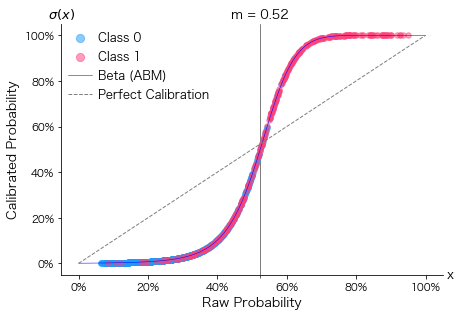

In [11]:
ax = visualize.calibration_curve(y_test, y_test_proba)

This produces the following calibration curve:

- The **dotted diagonal line** represents **perfect calibration**, where predicted probabilities match actual outcomes.
- The **blue line** shows the calibrated curve.
- The **points** represent the actual class outcomes.
- The **vertical line** marks **the inflection point** — where the calibration function transitions most steeply.

<div style="
    border-left: 5px solid #00b894;
    background-color: #ecfdf5;
    padding: 10px 15px;
    border-radius: 5px;
    font-family: 'Segoe UI', sans-serif;
">
💡 <b>Tip:</b>
To focus on a single class, apply a mask to your data before plotting:
<pre><code>self.plot(y_proba[y_true==1], y_true[y_true==1])</code></pre>
This displays the calibration curve only for samples belonging to <b>Class 1</b>.
</div>

**<font color="black" size=4> 4.2 Interpretation of Calibration Curve </font>**

- When the calibrated curve is **below** the diagonal, the model is **overconfident** (it predicts probabilities that are too high).
- When it is **above** the diagonal, the model is **underconfident**.
- _`m`_ indicates the point of steepest change, acting as the inflection point that shapes the calibration mapping.

**<font color="black" size=4> 4.3 Reliability Curve </font>** 

The reliability curve provides a statistical summary of calibration error across bins, including confidence intervals.

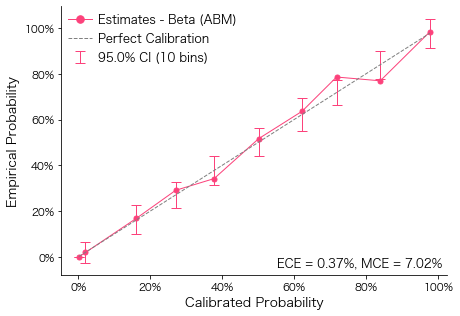

In [12]:
ax = visualize.reliability_curve(y_test, y_test_proba)

This produces the following reliability curve:

- The **dotted diagonal line** represents **perfect calibration**, where calibrated probabilities match empirical outcomes.
- The **pink markers** represents empirical probabilities (observed outcomes) versus predicted probabilities.
- The **error bars** denotes the confidence intervals across bins.
- **ECE (Expected Calibration Error)** and **MCE (Maximum Calibration Error)** summarize the overall and worst-case deviations from perfect calibration, respectively.

Mathematically:
$$ECE =\sum_{i=1}^{N} \frac{n_{i}}{N} \|acc(B_{i}) - conf(B_{i})\|$$
$$MCE= max_{i\in\{1,...,K\}} \|acc(B_{i}) - conf(B_{i})\|$$

Where:
- $K$: number of bins
- $n_{i}$: number of samples in bin 
- $N$: total number of samples
- $acc(B_{i})$: average empirical accuracy in bin $i$
- $conf(B_{i})$: average predicted confidence in bin $i$

**<font color="black" size=4> 4.4 Interpretation of Reliability Curve </font>**

- When the reliability curve is **below** the diagonal, the calibrated model **underestimates** probabilities. 
- When it is **above** the diagonal, the model **overestimates** probabilities.
- The error bars show the variability or uncertainty (confidence interval) of the empirical estimates across bins.

**<font color="blue" size=4> Example 2: Comparison of all Beta-calibration methods </font>**

In [13]:
# Initialize Calibration models
methods = {"Beta (ABM)": BetaCalibration("abm"),
           "Beta (AB)" : BetaCalibration("ab"),
           "Beta (AM)" : BetaCalibration("am"), 
           "Logistic"  : BetaCalibration("sigmoid")}

results = []

# Fit all calibrators and record parameters and metrics
for name, calibrator in methods.items():
    
    # Fit calibrator on test set
    calibrator.fit(y_test_proba, y_test)
    
    # Record parameters (a, b, c, m)
    params = calibrator.params_._asdict()
    data = {"Method": name, **params}
    
    # Evaluate performance on Test and Train sets
    loss_test  = calibrator.losses_._asdict()
    loss_train = calibrator.evaluate(y_train_proba, y_train)._asdict()

    # Add to result list
    data.update({f"{k}_Test": v[1] for k,v in loss_test.items()})
    data.update({f"{k}_Train": v[1] for k,v in loss_train.items()})
    results.append(data)

# MultiIndex columns
columns = [("Method", "") if key == "Method" else
           ("Parameters", key) if len(key)==1 else
           ("_".join(key.split("_")[:-1]), key.split("_")[-1])
           for key in data.keys()]

df = pd.DataFrame(results)
df.columns = pd.MultiIndex.from_tuples(columns)
df = df.sort_index(axis=1, level=0)

In [14]:
df

Method Parameters                     brier_score       ece_score  \
                       a      b      c     m        Test Train      Test   
0  Beta (ABM)      0.000  9.450 -7.005 0.523       0.038 0.018     0.007   
1   Beta (AB)      4.091  3.631  0.000 0.521       0.038 0.019     0.014   
2   Beta (AM)      3.861  3.861 -0.359 0.523       0.038 0.019     0.011   
3    Logistic     16.882 16.882 -8.768 0.519       0.038 0.019     0.009   

        log_loss        
  Train     Test Train  
0 0.018    0.141 0.073  
1 0.023    0.145 0.075  
2 0.022    0.145 0.075  
3 0.021    0.142 0.074